# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
print(df_offers.head())
print("----------------Offers----------------")
print(df_offers.offer_id)


   offer_id  campaign            varietal  min_qty  discount       origin  \
0         1   January              Malbec       72        56       France   
1         2   January          Pinot Noir       72        17       France   
2         3  February           Espumante      144        32       Oregon   
3         4  February           Champagne       72        48       France   
4         5  February  Cabernet Sauvignon      144        44  New Zealand   

   past_peak  
0      False  
1      False  
2       True  
3       True  
4       True  
----------------Offers----------------
0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
25    26
26    27
27    28
28    29
29    30
30    31
31    32
Name: offer_id, dtype: int64


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn
#Merge
offer_customers = df_offers.merge(df_transactions, how = 'left', left_on = 'offer_id', right_on = 'offer_id')
print(offer_customers.head())

   offer_id campaign varietal  min_qty  discount  origin  past_peak  \
0         1  January   Malbec       72        56  France      False   
1         1  January   Malbec       72        56  France      False   
2         1  January   Malbec       72        56  France      False   
3         1  January   Malbec       72        56  France      False   
4         1  January   Malbec       72        56  France      False   

  customer_name  n  
0        Thomas  1  
1       Jackson  1  
2      Mitchell  1  
3      Peterson  1  
4          Wood  1  


In [5]:
#Then pivot
customer_offer = pd.pivot_table(offer_customers, values = 'n', index = ['customer_name'], columns = ['offer_id'], fill_value = 0)
customer_offer.reset_index(inplace = True)
print(customer_offer.shape)
print(customer_offer.head())


(100, 33)
offer_id customer_name  1  2  3  4  5  6  7  8  9 ...  23  24  25  26  27  28  \
0                Adams  0  0  0  0  0  0  0  0  0 ...   0   0   0   0   0   0   
1                Allen  0  0  0  0  0  0  0  0  1 ...   0   0   0   0   1   0   
2             Anderson  0  0  0  0  0  0  0  0  0 ...   0   1   0   1   0   0   
3               Bailey  0  0  0  0  0  0  1  0  0 ...   0   0   0   0   0   0   
4                Baker  0  0  0  0  0  0  1  0  0 ...   0   0   0   0   0   0   

offer_id  29  30  31  32  
0          1   1   0   0  
1          0   0   0   0  
2          0   0   0   0  
3          0   1   0   0  
4          0   0   1   0  

[5 rows x 33 columns]


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

### My Response ###

An actual value of SS is difficult to determine as it depends on the data. In general lower values of SS correspond to better clustering because SS measures the squared distance from the centroid, with the best clusterings minimizing the distance. 

Looking at the generated elbow chart, there doesn't seem to be a clear winner in terms of K. I'll pick K=5 as there is some bend but K=8 could also be an equal option. There are only 100 observations so the more clusters we pick the less meaningful each cluster could become. Given the subjectivity of a visual determination I'd want a clearer idication kf the right K to pick. 

<class 'numpy.matrixlib.defmatrix.matrix'>


Text(0.5, 1.0, 'SS between 2 & 10 Clusters')

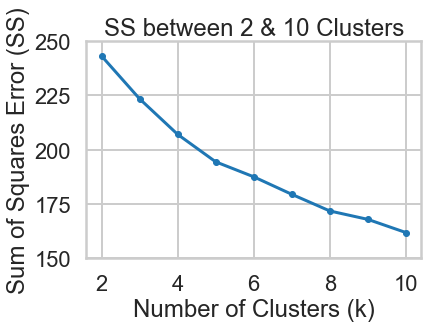

In [6]:
# your turn
#Create a numpy matrix `x_cols` with only the columns 
#representing the offers (i.e. the 0/1 colums) 
import numpy as np
x_cols = np.matrix(customer_offer.iloc[:,2:33])
print(type(x_cols))
x_cols


#Write code that applies the [`KMeans`]
from sklearn.cluster import KMeans

k_range = range(2,11)
kmeans_ss = [KMeans( n_clusters = k, random_state = 5 ).fit(x_cols).inertia_ for k in k_range]

#Construct a plot showing SS for each K and pick K using this plot
# make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, kmeans_ss,".-")
ax.set_ylim((150, 250))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squares Error (SS)')
plt.title('SS between 2 & 10 Clusters')

Text(0.5, 1.0, 'Membership Counts for Each Cluster, using 5 Clusters')

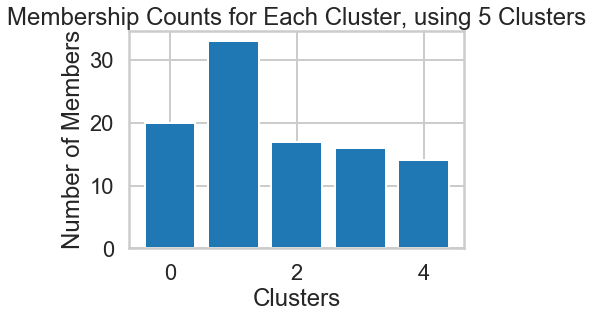

In [7]:
# count membership using k = 5

# extract counts of cluster membership
best_k = 5
best_k_clusters = KMeans(n_clusters = best_k, random_state = 5)
customer_offer['cluster'] = best_k_clusters.fit_predict(np.matrix(customer_offer.iloc[:,2:33]))

# transform counts into dataframe for easier graphing
counts = pd.DataFrame(customer_offer.cluster.value_counts())
counts.columns = ['count']
counts['cluster'] = counts.index

# plot the membership each cluster
plt.bar(list(counts['cluster']),list(counts['count']))
plt.xlabel('Clusters')
plt.ylabel('Number of Members')
plt.title('Membership Counts for Each Cluster, using 5 Clusters')

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.09467039888175721
For n_clusters = 3 The average silhouette_score is : 0.12435687906779831
For n_clusters = 4 The average silhouette_score is : 0.10621743538339512
For n_clusters = 5 The average silhouette_score is : 0.147526815597879
For n_clusters = 6 The average silhouette_score is : 0.1210322727880898
For n_clusters = 7 The average silhouette_score is : 0.13526470702979365
For n_clusters = 8 The average silhouette_score is : 0.11806245461314173
For n_clusters = 9 The average silhouette_score is : 0.11884325671281097
For n_clusters = 10 The average silhouette_score is : 0.10326267746039294
For n_clusters = 11 The average silhouette_score is : 0.1321195364417116


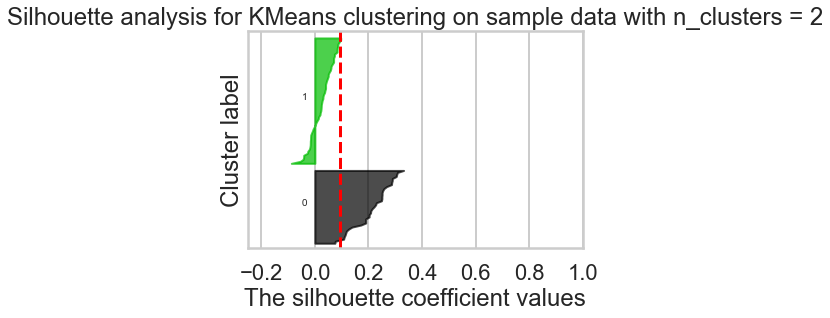

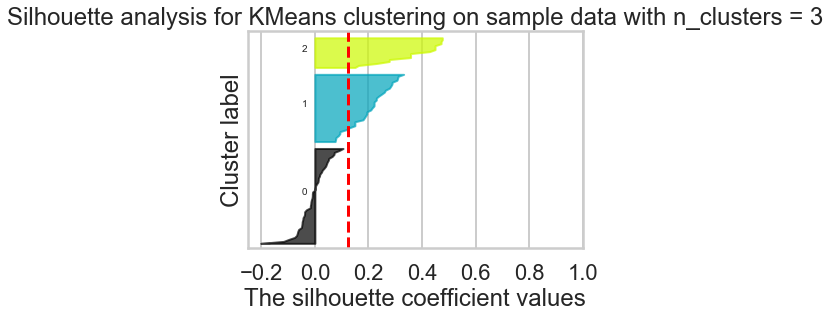

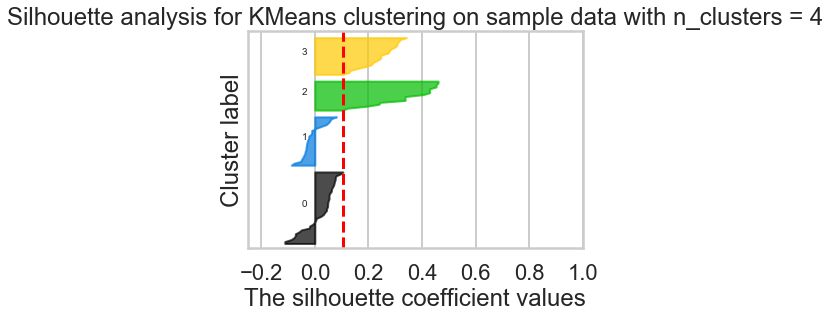

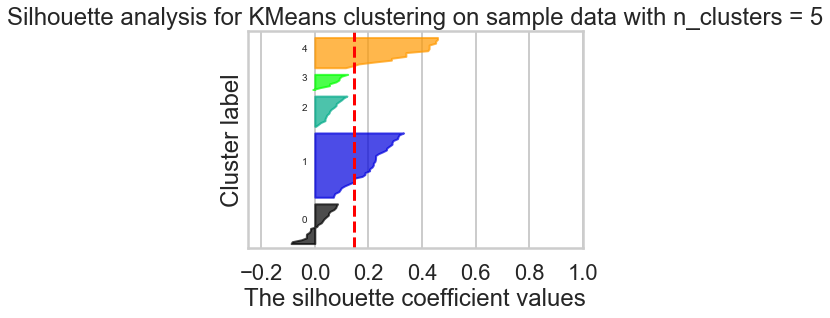

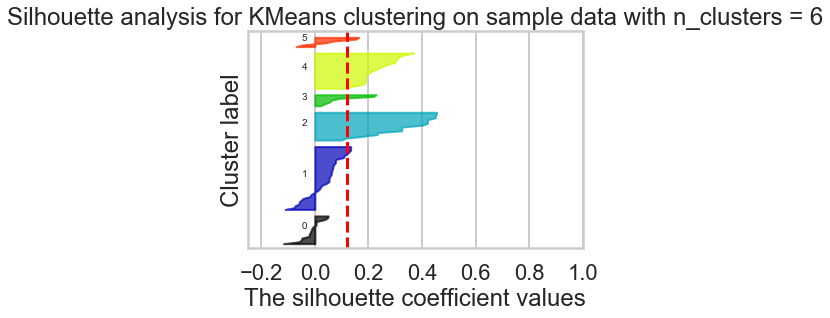

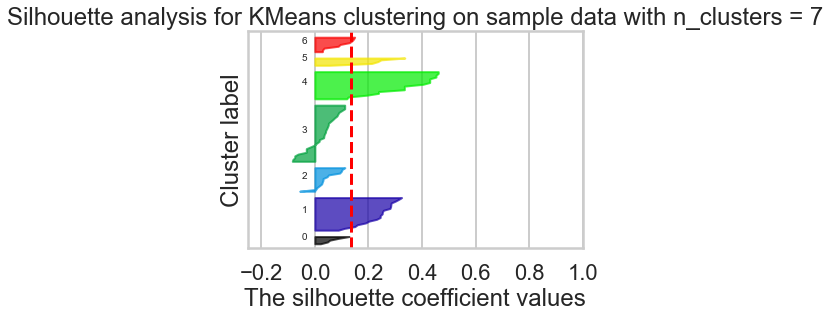

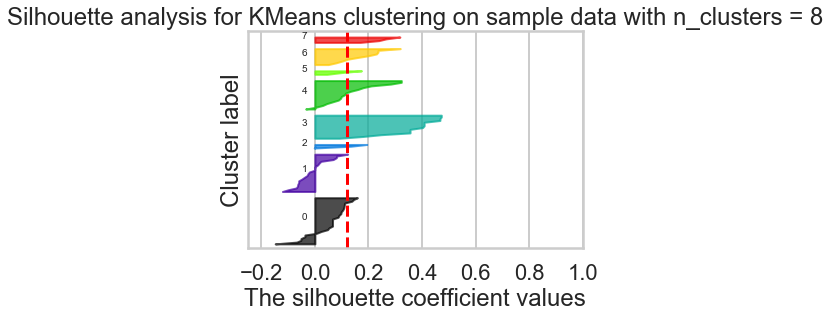

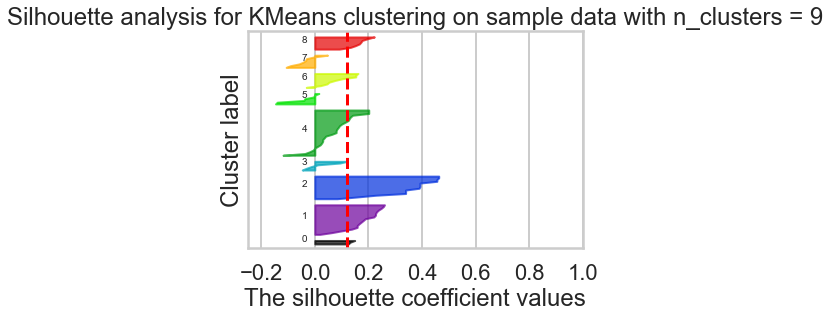

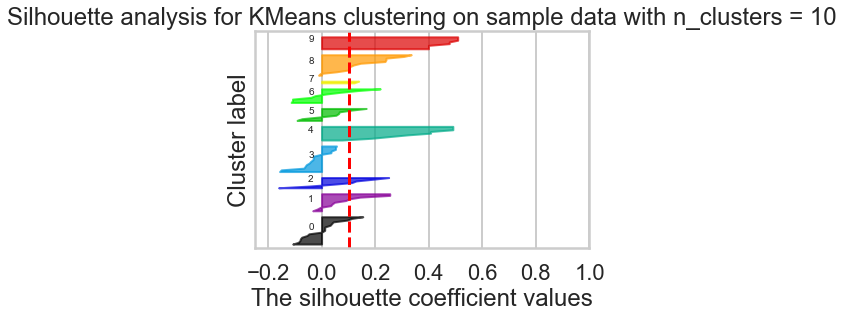

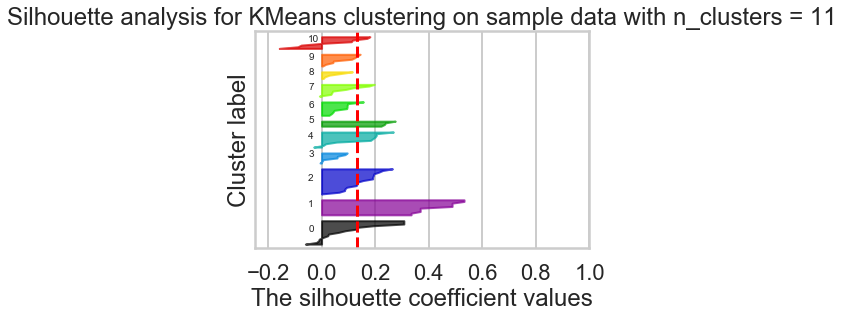

In [8]:
# Your turn.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np



range_n_clusters = range(2,12)

for n_clusters in range_n_clusters:
    
    
    # Build the K-means and get cluster labels
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(x_cols)
    
    
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)
    
    # Build graphs for the distances in each cluster
    
    
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    fig, ax = plt.subplots(1, 1)
    ax.set_xlim([-0.25, 0.6])
    # The (n_clusters+1)*2.5 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(x_cols) + (n_clusters + 1) * 2.5])


    y_lower = 2.5
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        
        # Sort in default (ascending) order
        ith_cluster_silhouette_values.sort()

        # Find out how many obs in the cluster
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        
        # Set an upper bound based for the individual cluster
        y_upper = y_lower + size_cluster_i

        # Set a color for the plot of distances in this cluster
        color = cm.nipy_spectral(float(i) / n_clusters)
        
        # Fill graph with data
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # label axes and set for next cluster
        # Label plot areas for cluster
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        # Provide space between plots for each cluster
        y_lower = y_upper + 2.5  # 10 for the 0 samples

    ax.set_title("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters)
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])


plt.show()


### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

### My Response

#### Based on what you see, what seems to be the best value for K? 
#### Moreover, which method of choosing K seems to have produced the optimal result visually? 

The methods we've explored to decide on the best K possible include: the Elbow method, the Silhouette method (graphs and scores) and the scatterplots. 

Each method has pros and cons but in terms of visual interpretability (from least decipherable to most), the Silhouette graphs were the most difficult for me to understand with the Elbow chart being the most decipherable to me. One significant drawback of all these methods is that they are subjective and in the case of this dataset, K=8 could have been a reasonabke option based on just the elbow chart. The scatter plot method and sihouettes charts also offered other options. 

Combined all together, the Silhouette scores offered the clearest distinction of K options. In future exercises with data similar to the wine dataset, I would most likely employe several different methods to choose the best K.   



#### Exercise: Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

If we look at the charts generated below, we can see that clusters were strongly distinguished by responsiveness to wine varietals, months and country of origin (to some degree). For most of the clusters country origin was the least disintiguishable feature.

Cluster 0 - Showed strong preference for champagne (and some preference for prosecco). The most popular campaign months were March, December, August, and February. Most popular winer origins were France (and somewhat Chile).   

Cluster 1 - Showed a strong preference for Espumante (with Malbec, Pinot Grigio, and Prosecco sharing a secondary place). Most popular months were July, November, and December. Preferred country of origin being France (with South Africa, Oregon, and Australia sharing second place).  

Cluster 2 - Pinot Noir was the most popular varietal for this group. Country of origins preferred were Australia and Italy. Campaign months were September and October. 

Cluster 3 - This group displayed a near equal preference for Chardonnay, Champagne, and Cabarnet. Most popular campaign month was June and preferred countries of origin being France and Germany.

Cluster 4 - This group had a strong preference for Champagne (with a secondary preference for Cabarnet). Country of origin preferred was France and most popular campaign months being May and August.


The most interesting pieces of information relating to the clusters would be the wine varietals and the campaign months as both near exclusivity to the cluster profiles. These could correspond to specific shooper personas and a great action item for business owners doing similar analysis could be to understand the customer personas and design targeted campaigns in order to drive purchase. 

In [9]:
#your turn
import numpy as np
from sklearn.decomposition import PCA

#Create the pca object
pca = PCA(n_components = 2)
wine_factors = np.matrix(pca.fit_transform(x_cols))

#Get the 2 components into a dataframe 
wine_factors_df = pd.DataFrame(wine_factors)
wine_factors_df.columns = ['x','y']
print(wine_factors_df.head())


#Get names from customer_offer list, initialize x/y columns in new dataframe
# ==> Create condensed data frame 
wine_clusters = pd.DataFrame(customer_offer.iloc[:,0])
print(wine_clusters.head())
wine_clusters['x'], wine_clusters['y'] = wine_factors_df['x'], wine_factors_df['y']
print(wine_clusters.head())

# add cluster labels using the same k-range as used above
for k in k_range:
    
    # calculate cluster labels
    # a random state of 5 is used for consistency with the above results
    clusterer = KMeans( n_clusters = k, random_state = 42 )
    cluster_labels = clusterer.fit_predict(wine_factors)
    
    # append labels to dataframe
    wine_clusters[str('clusters_' + str(k))] = cluster_labels

print(wine_clusters.head())

          x         y
0  1.014908  0.157764
1 -0.313043  0.019268
2 -0.451462  1.008114
3  0.700551  0.006002
4  0.072574 -0.494352
  customer_name
0         Adams
1         Allen
2      Anderson
3        Bailey
4         Baker
  customer_name         x         y
0         Adams  1.014908  0.157764
1         Allen -0.313043  0.019268
2      Anderson -0.451462  1.008114
3        Bailey  0.700551  0.006002
4         Baker  0.072574 -0.494352
  customer_name         x         y  clusters_2  clusters_3  clusters_4  \
0         Adams  1.014908  0.157764           0           1           0   
1         Allen -0.313043  0.019268           1           0           3   
2      Anderson -0.451462  1.008114           1           2           1   
3        Bailey  0.700551  0.006002           0           1           0   
4         Baker  0.072574 -0.494352           1           0           2   

   clusters_5  clusters_6  clusters_7  clusters_8  clusters_9  clusters_10  
0           3           4   

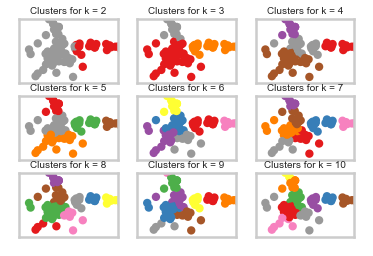

In [10]:
# Creating the scatterplots

# set x and y limits for the plots
# will use range, +/- 5% of the range for min, max
x_range = np.ptp(wine_clusters['x'])
x_min, x_max = np.min(wine_clusters['x']) - 0.10 * x_range, np.max(wine_clusters['x']) - 0.10 * x_range

y_range = np.ptp(wine_clusters['y'])
y_min, y_max = np.min(wine_clusters['y']) - 0.10 * y_range, np.max(wine_clusters['y']) - 0.10 * y_range

# setup figure and fill with data
fig = plt.figure()
for k in k_range:    
    # setup plots and axes
    ax = fig.add_subplot(3,3,k-1)
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_xticks([])
    ax.set_yticks([])
    
    # fill data in the scatterplots
    plt.scatter(x = wine_clusters['x'], y = wine_clusters['y'], s = 40,
                c = wine_clusters.iloc[:,k + 1], cmap = 'Set1')
    ax.set_title('Clusters for k = ' + str(k),fontsize=10)

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

In [11]:
### Creating dataframe for storytelling part

cols_to_keep = ['customer_name','cluster']
cluster_dfs = customer_offer[cols_to_keep]

clusterLabeled_offer_customers = offer_customers.merge(cluster_dfs, how = 'left', left_on = 'customer_name', right_on = 'customer_name')
print(clusterLabeled_offer_customers.head())
print("\n")


   offer_id campaign varietal  min_qty  discount  origin  past_peak  \
0         1  January   Malbec       72        56  France      False   
1         1  January   Malbec       72        56  France      False   
2         1  January   Malbec       72        56  France      False   
3         1  January   Malbec       72        56  France      False   
4         1  January   Malbec       72        56  France      False   

  customer_name  n  cluster  
0        Thomas  1        3  
1       Jackson  1        4  
2      Mitchell  1        2  
3      Peterson  1        2  
4          Wood  1        0  




                  value
cluster campaign       
4       12            8
        11            6
        10            4
        8            10
        6             3
        5            13
        3             1
        2             3
        1             6
3       12            3
        10            7
        9             3
        8             5
        6            12
        5             3
        4             9
        3             2
        2             9
        1             3
2       10           13
        9            13
        7             7
        6             1
        5             1
        4             1
        1             9
1       12           16
        11           17
        10            1
        8             1
        7            13
        5             7
        4             1
        3            31
0       12           16
        10            5
        9             1
        8            15
        7             6
        6       

C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


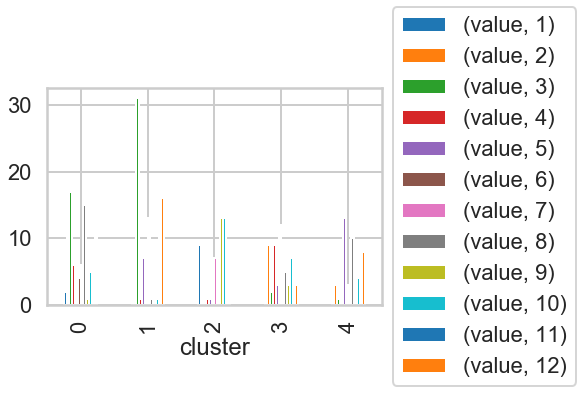

In [12]:
### Examining clusters by campaign month

clusterVcampaign = pd.DataFrame(clusterLabeled_offer_customers.groupby(['cluster', 'campaign']).size())
clusterVcampaign.columns=['value']



def map_level(df, dct, level=0):
    index = df.index
    index.set_levels([[dct.get(item, item) for item in names] if i==level else names
                      for i, names in enumerate(index.levels)], inplace=True)

months = {"January":1,"February":2,"March":3,"April":4,"May":5, "June":6,"July":7,"August":8,"September":9,"October":10,"November":11, "December":12}
map_level(clusterVcampaign, months, level=1)

clusterVcampaign.sort_index(level=[0,1],ascending=False,inplace=True)


print(clusterVcampaign)
print("\n")
#clusterVcampaign = clusterVcampaign.set_index(['cluster','company']).value


#clusterVcampaign.unstack().plot(kind='bar', stacked=True)

fig = clusterVcampaign.unstack().plot(kind='bar',legend=False)
ax = plt.subplot(111)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


                            value
cluster varietal                 
4       Prosecco                3
        Pinot Noir              3
        Pinot Grigio            1
        Merlot                  2
        Malbec                  7
        Espumante               2
        Champagne              23
        Cabernet Sauvignon     13
3       Prosecco                2
        Pinot Noir              3
        Merlot                  9
        Malbec                  4
        Chardonnay             12
        Champagne              13
        Cabernet Sauvignon     13
2       Prosecco                2
        Pinot Noir             38
        Merlot                  1
        Malbec                  2
        Chardonnay              1
        Champagne               1
1       Prosecco               17
        Pinot Grigio           16
        Merlot                  6
        Malbec                 16
        Espumante              29
        Champagne               2
        Cabern

C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


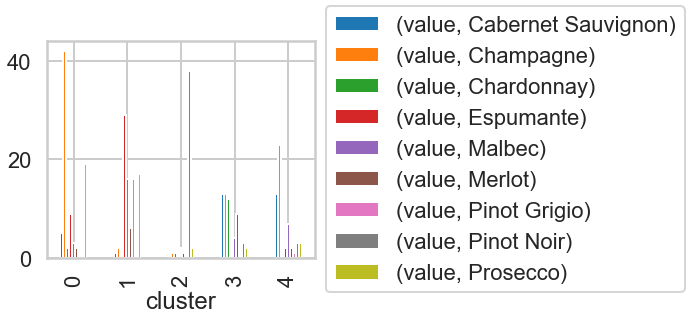

In [13]:
### Examining clusters by varietal

clusterVvarietal = pd.DataFrame(clusterLabeled_offer_customers.groupby(['cluster', 'varietal']).size())
clusterVvarietal.columns=['value']
clusterVvarietal.sort_index(level=[0,1],ascending=False,inplace=True)


print(clusterVvarietal)
print("\n")

fig = clusterVvarietal.unstack().plot(kind='bar',legend=False)
ax = plt.subplot(111)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

                      value
cluster origin             
4       South Africa      1
        Oregon            5
        Italy             3
        Germany           1
        France           39
        Chile             1
        California        1
        Australia         3
3       South Africa      3
        Oregon            2
        New Zealand       6
        Italy             6
        Germany           1
        France           15
        Chile            17
        California        3
        Australia         3
2       South Africa      1
        New Zealand       1
        Italy            12
        Germany           7
        France            9
        California        2
        Australia        13
1       South Africa     16
        Oregon           13
        New Zealand       1
        France           33
        Chile             7
        California        2
        Australia        15
0       South Africa      4
        Oregon            6
        New Zealand 

C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


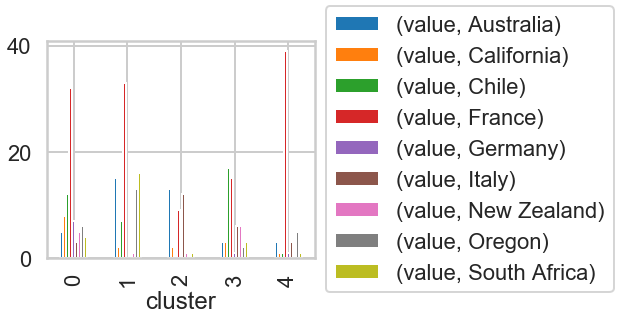

In [14]:
### Examining clusters by origin

clusterVorigin = pd.DataFrame(clusterLabeled_offer_customers.groupby(['cluster', 'origin']).size())
clusterVorigin.columns=['value']
clusterVorigin.sort_index(level=[0,1],ascending=False,inplace=True)


print(clusterVorigin)
print("\n")

fig = clusterVorigin.unstack().plot(kind='bar',legend=False)
ax = plt.subplot(111)

# Shrink current axis by 20%
box = fig.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

Looking at the chart below, it seems like values in the range of 2-4 could be the best number of dimensions.

Text(0.5, 1.0, 'Variance Explained vs. Components')

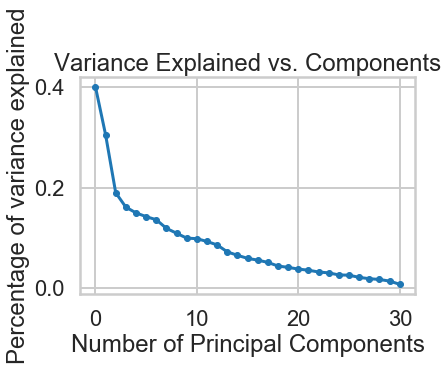

In [15]:
#your turn
# Initialize a new PCA model with a default number of components.

pca = PCA()
factors = pca.fit(x_cols)

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(factors.explained_variance_, '.-')
#ax.set_ylim((0,1))
plt.grid(True)
plt.xlabel('Number of Principal Components')
plt.ylabel('Percentage of variance explained')
plt.title('Variance Explained vs. Components')

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


### My Response

#### How do their results compare? Which performs the best? 
#### Tell a story why you think it performs the best.

The difference in number of clusters computed or assumed by each algorithm in calculating the Silhoutette scores seems to differ significantly enough that we would want to be careful about which we would use on a clustering project.

For Affinity Propagation, a k number isn't given and instead we provided a list of damping values and calculated silhouette scores. I also provided the number of cluster centers. The interesting feature is thagt the number of cluster indices jumps from 17 to 16 to 15 to 2. We had only tested k clusters from 2-10 which could indicate that from the perspective of the AP algorithm, an optimal k value wasn't clearly available. From the perspective of the wine set and given our earlier EDA, that fact the data set only includes 100 samples and has potentially has fairly even close knit clusters could be a big factor given AP performs best on uneven data sets. 

For Spectral Clustering the ideal K values were either 3 or 5 (further reinforcing the notion that a k of 5 is the most optimal). 

For Agglomerative clustering the ideal values of K seems to be 4 or 5.

For DBSCA the results are difficult to interpret. Similar to AP, it's possible that the wine data set is not the appropriate candidate given the small sample size and potentially even-ish clusters. Even visually from the prior scatter plots we could see that the data is fairly close together in terms of distance and could result in a very poor DBSCAN output. 

As to which algorithm performed best, I think it's fairly clear that DBSCAM and AP struggled to balance discernment with sensibility. There was very little convergence with the k= 3-5 range we identified earlier and the clusters themselves didn't make sense intuitively, given we only had 100 observations and some of the suggested cluster numbers (like 100, 19, etc) would have included very few members to do any sort of actionable analysis. 

Spectral clustering and Agglomerative clustering seemed to perform similarly and converged nicely with k=5, so either would seemingly be a good candidate in lieu of k-means clustering.  

In [16]:
#Affinity propagation - Doesn't require k clusters!
#Since it only takes damping and n_samples here is fixed, 
#we'll go through a list of possible damping values.

d_range = np.arange(0.5,1.0,0.05)

for d in d_range:
       
    clusterer = sklearn.cluster.AffinityPropagation(damping=d)
    cluster_labels = clusterer.fit_predict(x_cols)

    
       
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For d = %.2f the average silhouette_score: %.5f " %(d,silhouette_avg))
    print("# of Cluster Centers (Count of Indices):", len(clusterer.cluster_centers_))
    print("\n")

For d = 0.50 the average silhouette_score: 0.12768 
# of Cluster Centers (Count of Indices): 17


For d = 0.55 the average silhouette_score: 0.12768 
# of Cluster Centers (Count of Indices): 17


For d = 0.60 the average silhouette_score: 0.12768 
# of Cluster Centers (Count of Indices): 17


For d = 0.65 the average silhouette_score: 0.12768 
# of Cluster Centers (Count of Indices): 17


For d = 0.70 the average silhouette_score: 0.12768 
# of Cluster Centers (Count of Indices): 17


For d = 0.75 the average silhouette_score: 0.12768 
# of Cluster Centers (Count of Indices): 17


For d = 0.80 the average silhouette_score: 0.11032 
# of Cluster Centers (Count of Indices): 16


For d = 0.85 the average silhouette_score: 0.09355 
# of Cluster Centers (Count of Indices): 15


For d = 0.90 the average silhouette_score: 0.09355 
# of Cluster Centers (Count of Indices): 15


For d = 0.95 the average silhouette_score: 0.02291 
# of Cluster Centers (Count of Indices): 2




In [17]:
#Spectral Clustering - No. of clusters must be known in advance!
# We can use n_clusters

for k in k_range:
    clusterer = sklearn.cluster.SpectralClustering( n_clusters = k, random_state = 5 )
    cluster_labels = clusterer.fit_predict(x_cols)
    
    # obtain and report silhouette scores
    slht_avg = silhouette_score(x_cols, cluster_labels)
    print("For k = %.0f the average silhouette score: %.4f" % (k, slht_avg))

For k = 2 the average silhouette score: 0.0794
For k = 3 the average silhouette score: 0.1204
For k = 4 the average silhouette score: 0.0917
For k = 5 the average silhouette score: 0.1044
For k = 6 the average silhouette score: 0.0945
For k = 7 the average silhouette score: 0.0872
For k = 8 the average silhouette score: 0.0980
For k = 9 the average silhouette score: 0.0975
For k = 10 the average silhouette score: 0.0762


In [18]:
# Agglomerative clustering
# We can use the following inputs: number of clusters, linkage type, distance
# In this example I will just be changing the k means 
# Up to analyst to pick the K

for k in k_range:
    clusterer = sklearn.cluster.AgglomerativeClustering( n_clusters = k )
    cluster_labels = clusterer.fit_predict(x_cols)
    
    # obtain and report silhouette scores
    slht_avg = silhouette_score(x_cols, cluster_labels)
    print("For k = %.0f the average silhouette score: %.4f" % (k, slht_avg))

For k = 2 the average silhouette score: 0.0881
For k = 3 the average silhouette score: 0.1186
For k = 4 the average silhouette score: 0.1309
For k = 5 the average silhouette score: 0.1416
For k = 6 the average silhouette score: 0.1513
For k = 7 the average silhouette score: 0.1199
For k = 8 the average silhouette score: 0.1245
For k = 9 the average silhouette score: 0.1328
For k = 10 the average silhouette score: 0.1292


In [19]:
#DBSCAN
#When we try changing eps, the output shows 

eps_range =[0.2,0.6,1,2,4,5]
for eps in eps_range:
    
    clusterer = sklearn.cluster.DBSCAN(eps=eps)
    cluster_labels = clusterer.fit_predict( x_cols )
    print("EPS output: %.2f" % eps)
    print(cluster_labels)
    print("\n")   
    
min_s_range = [1,2,3]

for s in min_s_range:
    clusterer2 = sklearn.cluster.DBSCAN( min_samples = s )
    cluster_labels = clusterer2.fit_predict(x_cols)
    
    slht_avg = silhouette_score(x_cols, cluster_labels)
    print("For min_samples = %.0f, the average silhouette scores is %.4f." % (s, slht_avg))
    print("No. of Core Sample Indices:", len(clusterer2.core_sample_indices_))
    print("\n")

EPS output: 0.20
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]


EPS output: 0.60
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]


EPS output: 1.00
[ 0 -1  1  2 -1 -1  1  2 -1  2 -1  1  2 -1 -1  1 -1  1  0 -1  2  2 -1 -1
  1 -1 -1 -1 -1 -1  3 -1 -1 -1 -1 -1 -1  2 -1 -1  1  1  2 -1 -1 -1  2 -1
 -1 -1 -1 -1 -1  1 -1  2  1  3  0 -1 -1  2 -1  0  0 -1  1 -1 -1 -1 -1 -1
 -1  3 -1  2  1 -1 -1  1 -1 -1 -1  1  2 -1  0 -1 -1  2 -1  0 -1  2 -1 -1
  2 -1 -1 -1]


EPS output: 2.00
[ 0  0  